In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Batch
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2, FakeKolkataV2, FakeTorino
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, slice_by_depth
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices

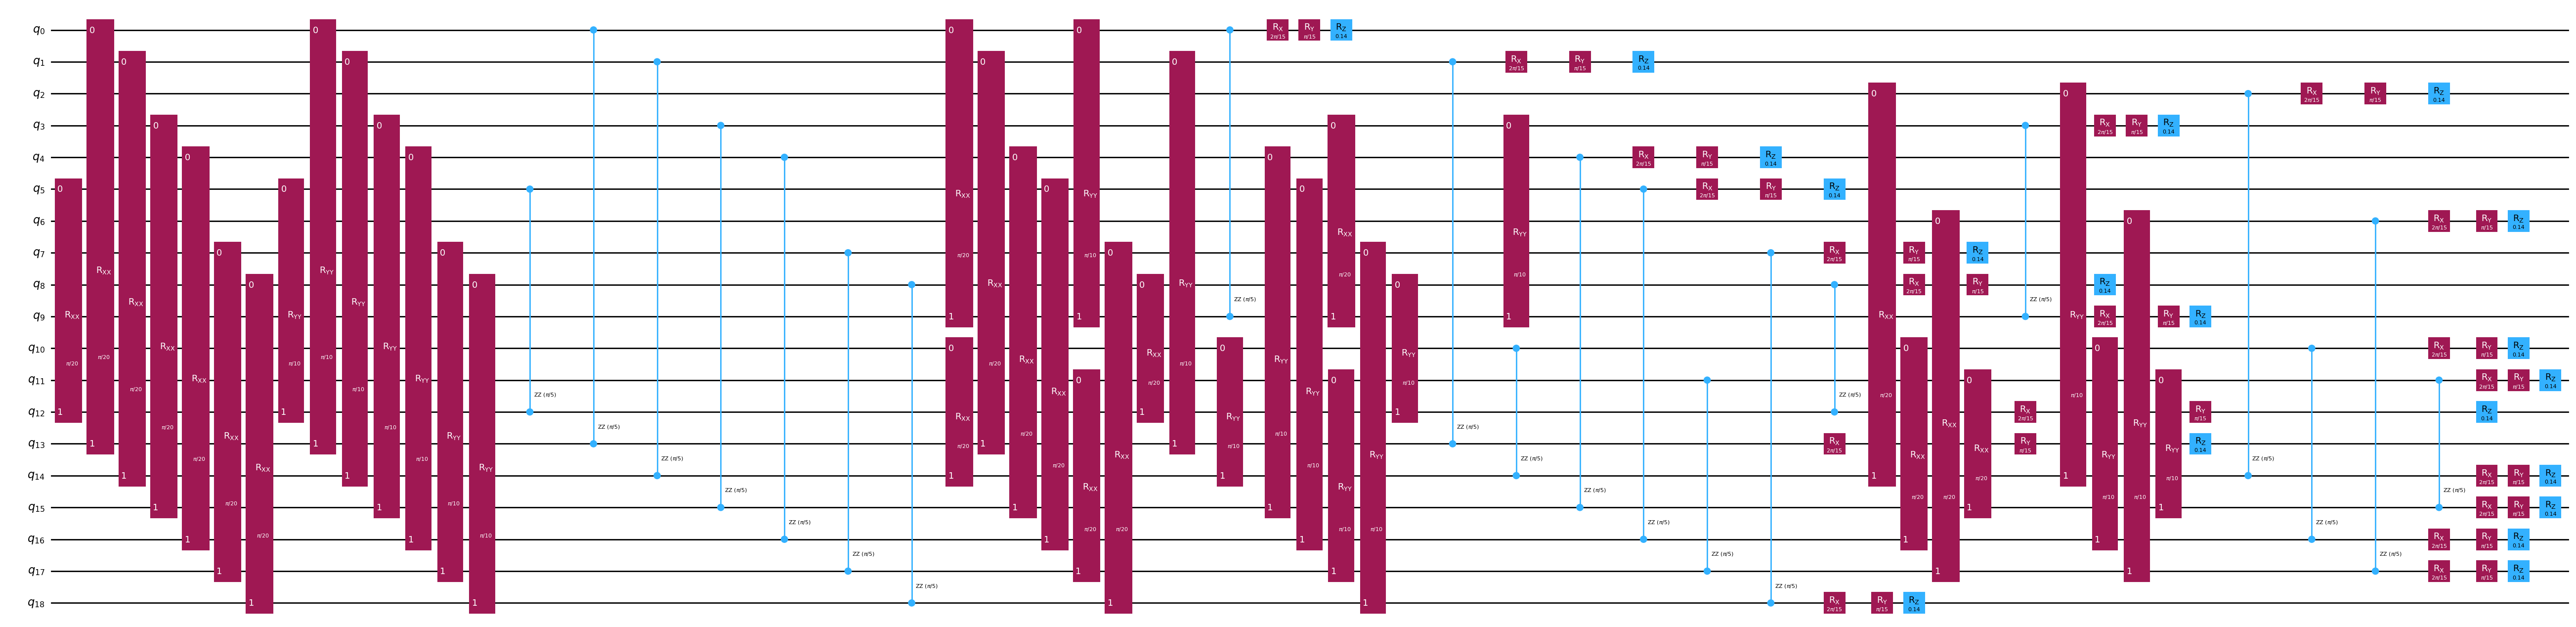

In [2]:
coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=True)

#reduced_coupling_map = coupling_map.reduce(
#    [0, 13, 1, 14, 10, 16, 5, 12, 8, 18, 7, 17, 11, 15, 3]
#)

# Get a qubit operator describing the Heisenberg XYZ model
hamiltonian = generate_xyz_hamiltonian(
    coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)

# we evolve for some time
circuit = generate_time_evolution_circuit(
    hamiltonian, synthesis=LieTrotter(reps=1), time=0.2
)

circuit.draw("mpl", fold=-1)

In [3]:
n = 19
observable_terms = [
            "I"*(i-1) + "Z" + "I"*(n - i)
            for i in range(1, n+1)
        ]
observable = SparsePauliOp(observable_terms, coeffs=[1/(n)] * (n))
print(observable)

SparsePauliOp(['ZIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIII', 'IIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIZ'],
              coeffs=[0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j,
 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j,
 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j,
 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j,
 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j])


In [4]:
# estimator_ideal = EstimatorV2(mode=AerSimulator())
# result_ideal =(
#     estimator_ideal.run([(circuit, observable)]).result()[0].data.evs.item()
# )
# print("The ideal expectation value is : ", result_ideal)

In [5]:
backend = FakeTorino()

In [6]:
pm_basis = generate_preset_pass_manager(optimization_level=3, basis_gates=backend.configuration().basis_gates, seed_transpiler=1)
synth_circuit = pm_basis.run(circuit)

In [7]:
# Define an operator budget list
import numpy as np
max_qwc_groups = 18
op_budget = OperatorBudget(max_qwc_groups=max_qwc_groups)
# Slice the isa_circuit by depth
synthesized_slices = slice_by_depth(synth_circuit, max_slice_depth=1)
print(f"Slice_by_depth separated the circuit into {len(synthesized_slices)} slices.")

Slice_by_depth separated the circuit into 40 slices.


In [70]:
truncation_error_budget_list = []
max_error_per_slice_list = np.linspace(0.001,0.005,20)
for max_error_per_slice in max_error_per_slice_list:
    truncation_error_budget = setup_budget(max_error_per_slice=max_error_per_slice)
    truncation_error_budget_list.append(truncation_error_budget)


In [71]:
max_error_per_slice_list

array([0.001     , 0.00121053, 0.00142105, 0.00163158, 0.00184211,
       0.00205263, 0.00226316, 0.00247368, 0.00268421, 0.00289474,
       0.00310526, 0.00331579, 0.00352632, 0.00373684, 0.00394737,
       0.00415789, 0.00436842, 0.00457895, 0.00478947, 0.005     ])

In [69]:
# Backpropagate without the truncation error budget
bp_circuit_list =[]
commuting_groups_list=[] # Stores the list of the non-commuting groups after backpropagation
backpropagated_observable_list =[]

for trunc_budget in truncation_error_budget_list:
    backpropagated_observable, remaining_slices, metadata = backpropagate(
    observable,
    synthesized_slices,
    operator_budget=op_budget,
    truncation_error_budget=trunc_budget
    )
    # Recombine the slices remaining after backpropagation
    bp_circuit = combine_slices(remaining_slices, include_barriers=False)
    num_non_commuting_groups=backpropagated_observable.group_commuting()
    if bp_circuit != None:
        print(f"Depth of the backpropagated circuit is: ", bp_circuit.depth())
    else:
        print("No circuit left!, backpropagated circuit is not a Quantum circuit")
    bp_circuit_list.append(bp_circuit)
    commuting_groups_list.append(len(num_non_commuting_groups))
    backpropagated_observable_list.append(backpropagated_observable)

Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  17
Depth of the backpropagated circuit is:  17
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  17
Depth of the backpropagated circuit is:  17
Depth of the backpropagated circuit is:  17
Depth of the backpropagated circuit is:  16


In [58]:
# Form the list of cut circuits
bp_cut_circuit_list =[]
bp_num_cuts_list =[]
bp_cut_sampling_overhead_list =[]
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

for bp_circuit in bp_circuit_list:
    # Specify the size of the QPUs available
    device_constraints = DeviceConstraints(qubits_per_subcircuit=(bp_circuit.num_qubits/2)+1)

    bp_cut_circuit, bp_cut_metadata = find_cuts(bp_circuit, optimization_settings, device_constraints)
    #print(metadata)
    print(
        f'Found solution using {len(bp_cut_metadata["cuts"])} cuts with a sampling '
        f'overhead of {bp_cut_metadata["sampling_overhead"]}.\n'
        #f'Lowest cost solution found: {bp_metadata["minimum_reached"]}.'
    )
    bp_cut_circuit_list.append(bp_cut_circuit)
    bp_num_cuts_list.append(len(bp_cut_metadata["cuts"]))
    bp_cut_sampling_overhead_list.append(bp_cut_metadata["sampling_overhead"])


print(bp_cut_circuit_list)
print(bp_num_cuts_list)
print(bp_cut_sampling_overhead_list)

Found solution using 1 cuts with a sampling overhead of 9.0.

Found solution using 1 cuts with a sampling overhead of 9.0.

Found solution using 1 cuts with a sampling overhead of 9.0.

Found solution using 1 cuts with a sampling overhead of 9.0.

Found solution using 1 cuts with a sampling overhead of 9.0.

Found solution using 1 cuts with a sampling overhead of 9.0.

Found solution using 1 cuts with a sampling overhead of 9.0.

Found solution using 1 cuts with a sampling overhead of 9.0.

Found solution using 1 cuts with a sampling overhead of 9.0.

Found solution using 1 cuts with a sampling overhead of 9.0.

Found solution using 1 cuts with a sampling overhead of 9.0.

Found solution using 1 cuts with a sampling overhead of 9.0.

Found solution using 1 cuts with a sampling overhead of 9.0.

Found solution using 1 cuts with a sampling overhead of 9.0.

Found solution using 1 cuts with a sampling overhead of 9.0.

Found solution using 1 cuts with a sampling overhead of 9.0.

Found so

In [59]:
from qiskit_addon_cutting import cut_wires, expand_observables
qc_w_ancilla_list=[]
observables_expanded_list=[]
for cut_ckt, bp_obs, bp_ckt in zip(bp_cut_circuit_list, backpropagated_observable_list, bp_circuit_list):
    qc_w_ancilla = cut_wires(cut_ckt)
    observables_expanded = expand_observables(bp_obs.paulis, bp_ckt, qc_w_ancilla)
    qc_w_ancilla_list.append(qc_w_ancilla)
    observables_expanded_list.append(observables_expanded)
    
    
    #qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)
print(qc_w_ancilla_list)
print(observables_expanded_list)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x135ce5d90>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x424637dd0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x48cda0a10>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x48cda1eb0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3772a8830>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3772a9a60>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3772ab140>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3acef3d40>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3acef2720>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3acef14c0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3acef0260>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x46f6e5070>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x46f6e6690>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x46f6e79e0>, <qiskit.circuit.qua

In [60]:
from qiskit_addon_cutting import partition_problem

subcircuits_list =[]
subobservables_list =[]
for qc_w_anc, obs_expan in zip(qc_w_ancilla_list, observables_expanded_list):

    partitioned_problem = partition_problem(
        circuit=qc_w_anc, observables=obs_expan
    )
    subcircuits = partitioned_problem.subcircuits
    subobservables = partitioned_problem.subobservables
    print(
        f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
    )
    subcircuits_list.append(subcircuits)
    subobservables_list.append(subobservables)
    #subcircuits[1].draw("mpl")
print(subcircuits_list)
print(subobservables_list)

Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
[{0: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x36866da60>, 1: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x145ef8770>, 2: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x145efa570>, 3: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x145e2fe90>, 4: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x145e2fcb0>}, {0: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x145da56a0>, 1: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x13652fd40>, 2: <qiskit.circuit.quantu

In [61]:
from qiskit_addon_cutting import generate_cutting_experiments
pass_manager =generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=1)
subexperiments_list =[]
isa_subexperiments_list = []
for subckt, subobs in zip(subcircuits_list, subobservables_list):
    subexperiments, coefficients = generate_cutting_experiments(
        circuits=subckt, observables=subobs, num_samples=np.inf
    )
    total_subexperiments = sum(len(subexperiments[i]) for i in list(subexperiments.keys()))
    subexperiments_list.append(total_subexperiments)
    
    isa_subexperiments_obp_cut_trunc = {
        label: pass_manager.run(partition_subexpts)
        for label, partition_subexpts in subexperiments.items()
        }
    isa_subexperiments_list.append(isa_subexperiments_obp_cut_trunc)
print(subexperiments_list)
print(isa_subexperiments_list)

[156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 180, 180, 156, 180, 180, 180, 180]
[{0: [<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x145e74da0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x144cc6ea0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x368196f90>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x424635640>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x40d4cce30>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x144c3c710>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x16c5235f0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x144c3e0f0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x40546c9e0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x424634050>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3e1183860>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x472c474a0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object 

In [49]:
subexperiments_list[10:]

[156, 156, 156, 180, 180, 156, 180, 180, 180, 180]

In [64]:
max_error_per_slice_list

array([0.001     , 0.00121053, 0.00142105, 0.00163158, 0.00184211,
       0.00205263, 0.00226316, 0.00247368, 0.00268421, 0.00289474,
       0.00310526, 0.00331579, 0.00352632, 0.00373684, 0.00394737,
       0.00415789, 0.00436842, 0.00457895, 0.00478947, 0.005     ])

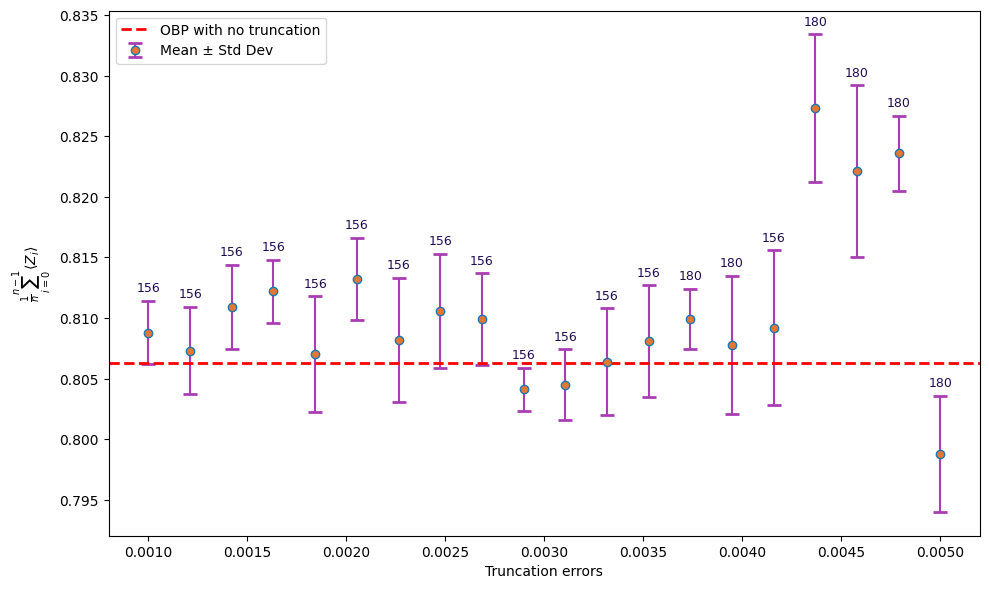

In [9]:
import matplotlib.pyplot as plt

# Given data
y_data = [
    (0.8088, 0.0026), (0.8073, 0.0036), (0.8109, 0.0035), (0.8122, 0.0026),
    (0.8070, 0.0048), (0.8132, 0.0034), (0.8082, 0.0051), (0.8106, 0.0047),
    (0.8099, 0.0038), (0.8041, 0.0018), (0.8045, 0.0029), (0.8064, 0.0044),
    (0.8081, 0.0046), (0.8099, 0.0025), (0.8078, 0.0057), (0.8092, 0.0064),
    (0.8273, 0.0061), (0.8221, 0.0071), (0.8236, 0.0031), (0.7988, 0.0048)
]

x_data = [0.001     , 0.00121053, 0.00142105, 0.00163158, 0.00184211,
          0.00205263, 0.00226316, 0.00247368, 0.00268421, 0.00289474,
          0.00310526, 0.00331579, 0.00352632, 0.00373684, 0.00394737,
          0.00415789, 0.00436842, 0.00457895, 0.00478947, 0.005     ]

ideal_value = 0.8062934484751276

values_to_display = [156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 180, 180, 156, 180, 180, 180, 180]

# Extract mean and std dev from y_data
means = [point[0] for point in y_data]
std_devs = [point[1] for point in y_data]

# Sort data by x for line connection clarity
sorted_data = sorted(zip(x_data, means, std_devs, values_to_display))
x_sorted, means_sorted, stds_sorted, values_sorted = zip(*sorted_data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.errorbar(
    x_sorted, means_sorted, yerr=stds_sorted, fmt='o', 
    capsize=5, ecolor="#a93db3", capthick=2, label='Mean ± Std Dev', 
    markerfacecolor="#E37734"
)

# Add the values on top of each error bar cap
for x, mean, std, val in zip(x_sorted, means_sorted, stds_sorted, values_sorted):
    plt.text(x, mean + std + 0.0005, str(val), ha='center', va='bottom', fontsize=9, color="#200b51")

# Plot the ideal value line
plt.axhline(ideal_value, color='red', linestyle='--', linewidth=2, label='OBP with no truncation')

# Labels and legend
plt.xlabel("Truncation errors")
plt.ylabel(r"$\frac{1}{n}\sum_{i=0}^{n-1}\langle Z_i \rangle$")
plt.legend()
plt.tight_layout()
plt.show()
